In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm import tqdm

custom_params = {"axes.spines.right": True, "axes.spines.top": True}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format="retina"

In [2]:
import lightning as L

from txtox.data.datamodules import PyGAnnDataGraphDataModule
from txtox.models.gnn_het_reg_2d_msl import LitGNNHetReg2dMSL
from txtox.utils import get_paths

n_genes = 500
n_labels = 188
paths = get_paths()

# data
datamodule = PyGAnnDataGraphDataModule(
    data_dir=paths["data_root"],
    file_names=["test_3section_hemi_v1.h5ad"],
    cell_type="subclass",
    spatial_coords=["x_section", "y_section", "z_section"],
    batch_size=200,
    n_hops=2,
)

expname = "20250504_233233_3_sec_hemi_msl_zerogamma"
zero_gamma = 1
checkpoint_path = paths["data_root"] + f"checkpoints/{expname}/"
model = LitGNNHetReg2dMSL.load_from_checkpoint(
    checkpoint_path + "epoch=271-val_rmse_overall=0.08.ckpt",
    input_size=n_genes,
    n_labels=n_labels,
    zero_gamma=zero_gamma,
)


# setup for predictions
trainer = L.Trainer()  # use limit_predict_batches for test runs
predictions = trainer.predict(model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/rohan/miniconda3/envs/txtox-torch-gpu/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [3]:
# xy_loc_pred = np.concatenate([p[0].reshape(1, -1) for p in predictions], axis=0)
# xy_mu_pred = np.concatenate([p[1].reshape(1, -1) for p in predictions], axis=0)
# xy_L_pred = np.concatenate([p[2].reshape(1, 2, 2) for p in predictions], axis=0)
# celltype_pred = np.concatenate([p[3].reshape(1, -1) for p in predictions], axis=0)

xy_mu_pred = np.concatenate([predictions[batch][0] for batch in range(len(predictions))], axis=0)
xy_L_pred = np.concatenate([predictions[batch][1] for batch in range(len(predictions))], axis=0)
xy_gamma_pred = np.concatenate([predictions[batch][2] for batch in range(len(predictions))], axis=0)
celltype_pred = np.concatenate([predictions[batch][3] for batch in range(len(predictions))], axis=0)


print(xy_mu_pred.shape)
print(xy_L_pred.shape)
print(xy_gamma_pred.shape)
print(celltype_pred.shape)

(159895, 2)
(159895, 2, 2)
(159895, 2)
(159895, 188)


In [4]:
# convert L to covariance matrices using L @ L.T
xy_cov_pred = xy_L_pred @ xy_L_pred.transpose(0, 2, 1)
print(xy_cov_pred.shape)

# calculates the eigenvalues and eigenvectors for all covariance matrices
eigvals, eigvecs = np.linalg.eig(xy_cov_pred)

# order them in descending order of eigenvalues
order = np.argsort(-eigvals, axis=1)
eigvals_ord = np.take_along_axis(eigvals, order, axis=1)
eigvecs_ord = np.take_along_axis(eigvecs, order[:, np.newaxis, :], axis=2)

eigvals = eigvals_ord
eigvecs = eigvecs_ord
del eigvals_ord, eigvecs_ord

(159895, 2, 2)


In [5]:
# check if the eigenvectors are columns of the covariance matrix
ind = 55  # some arbitrary cell
sigma = xy_cov_pred[ind].squeeze()
v0 = eigvecs[ind, :, 0]
v1 = eigvecs[ind, :, 1]

lam = eigvals[ind, :]
# check if the eigenvectors are columns
assert np.allclose(sigma @ v0, lam[0] * v0)
assert np.allclose(sigma @ v1, lam[1] * v1)

assert np.allclose(np.linalg.norm(v0, axis=0), 1)
assert np.allclose(np.linalg.norm(v1, axis=0), 1)

In [6]:
path = get_paths()["data_root"] + "test_3section_hemi_v1.h5ad"
adata = ad.read_h5ad(path)
xy = adata.obs[["x_section", "y_section"]].values

In [7]:
adata.obs["z_section"].unique()

array([6.4, 6.8, 6.6])

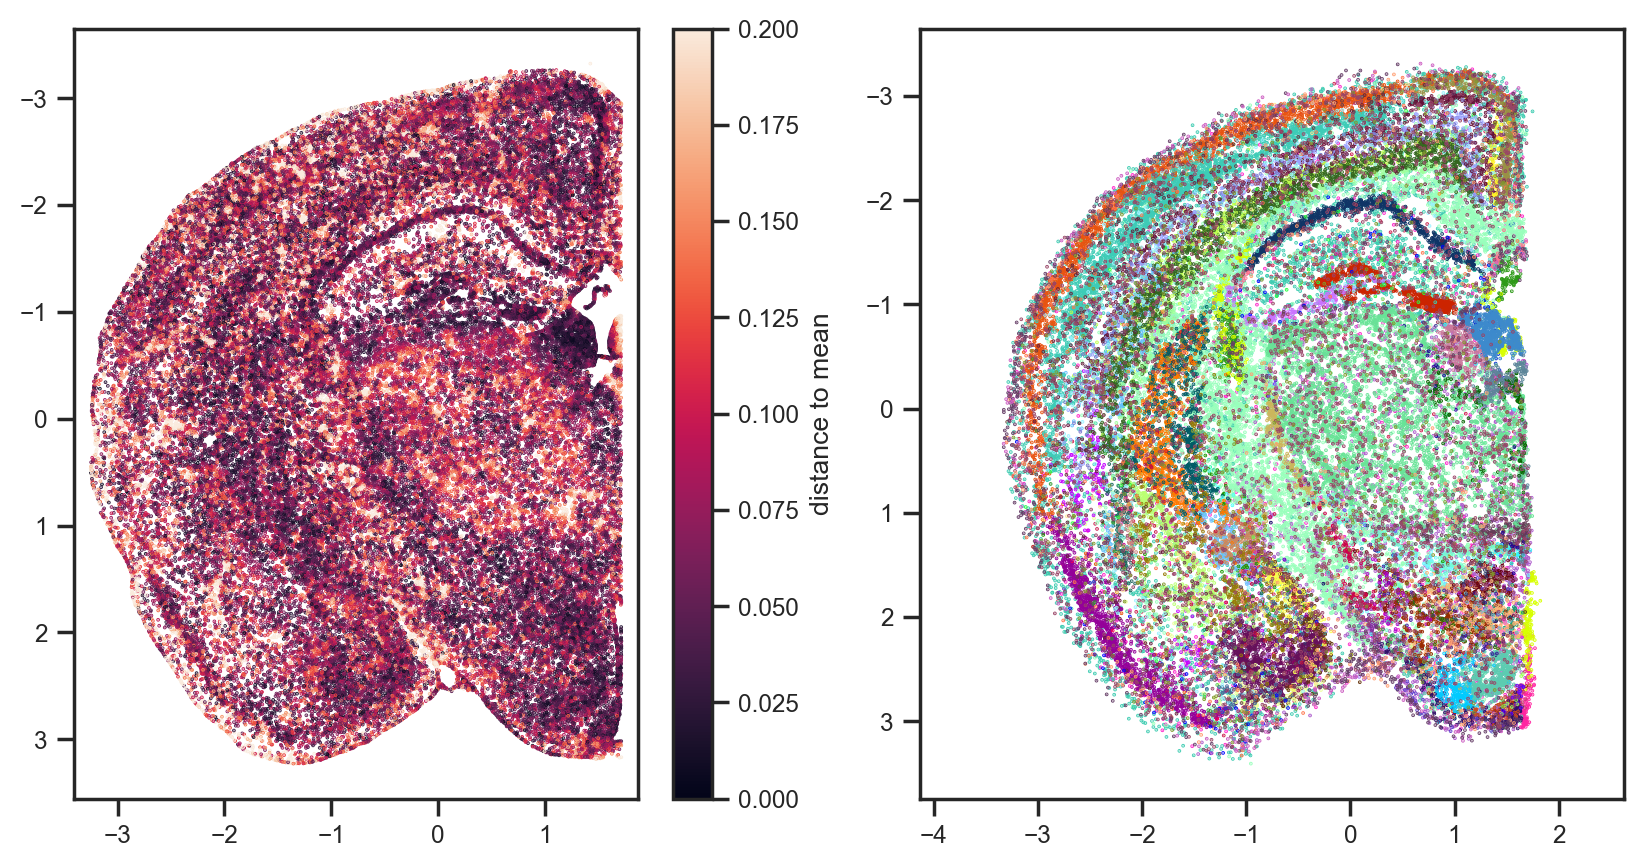

In [8]:
ind = np.where((adata.obs["x_section"] > -np.inf) & (adata.obs["z_section"].round(1) == 6.8))[0]

f, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].scatter(xy[ind, 0], xy[ind, 1], s=0.1, c=adata.obs["subclass_color"].iloc[ind], alpha=1)
c = np.linalg.norm(xy[ind] - xy_mu_pred[ind], axis=1)
ax[0].scatter(xy[ind, 0], xy[ind, 1], s=0.1, c=c, alpha=1, cmap="rocket", vmin=0, vmax=0.2)
sm = plt.cm.ScalarMappable(cmap="rocket", norm=plt.Normalize(vmin=0, vmax=0.2))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], label="distance to mean")
ax[0].axis("equal")
ax[0].invert_yaxis()


ax[1].scatter(xy_mu_pred[ind, 0], xy_mu_pred[ind, 1], s=0.1, c=adata.obs["subclass_color"].iloc[ind], alpha=1)
ax[1].axis("equal")
ax[1].invert_yaxis()
plt.show()

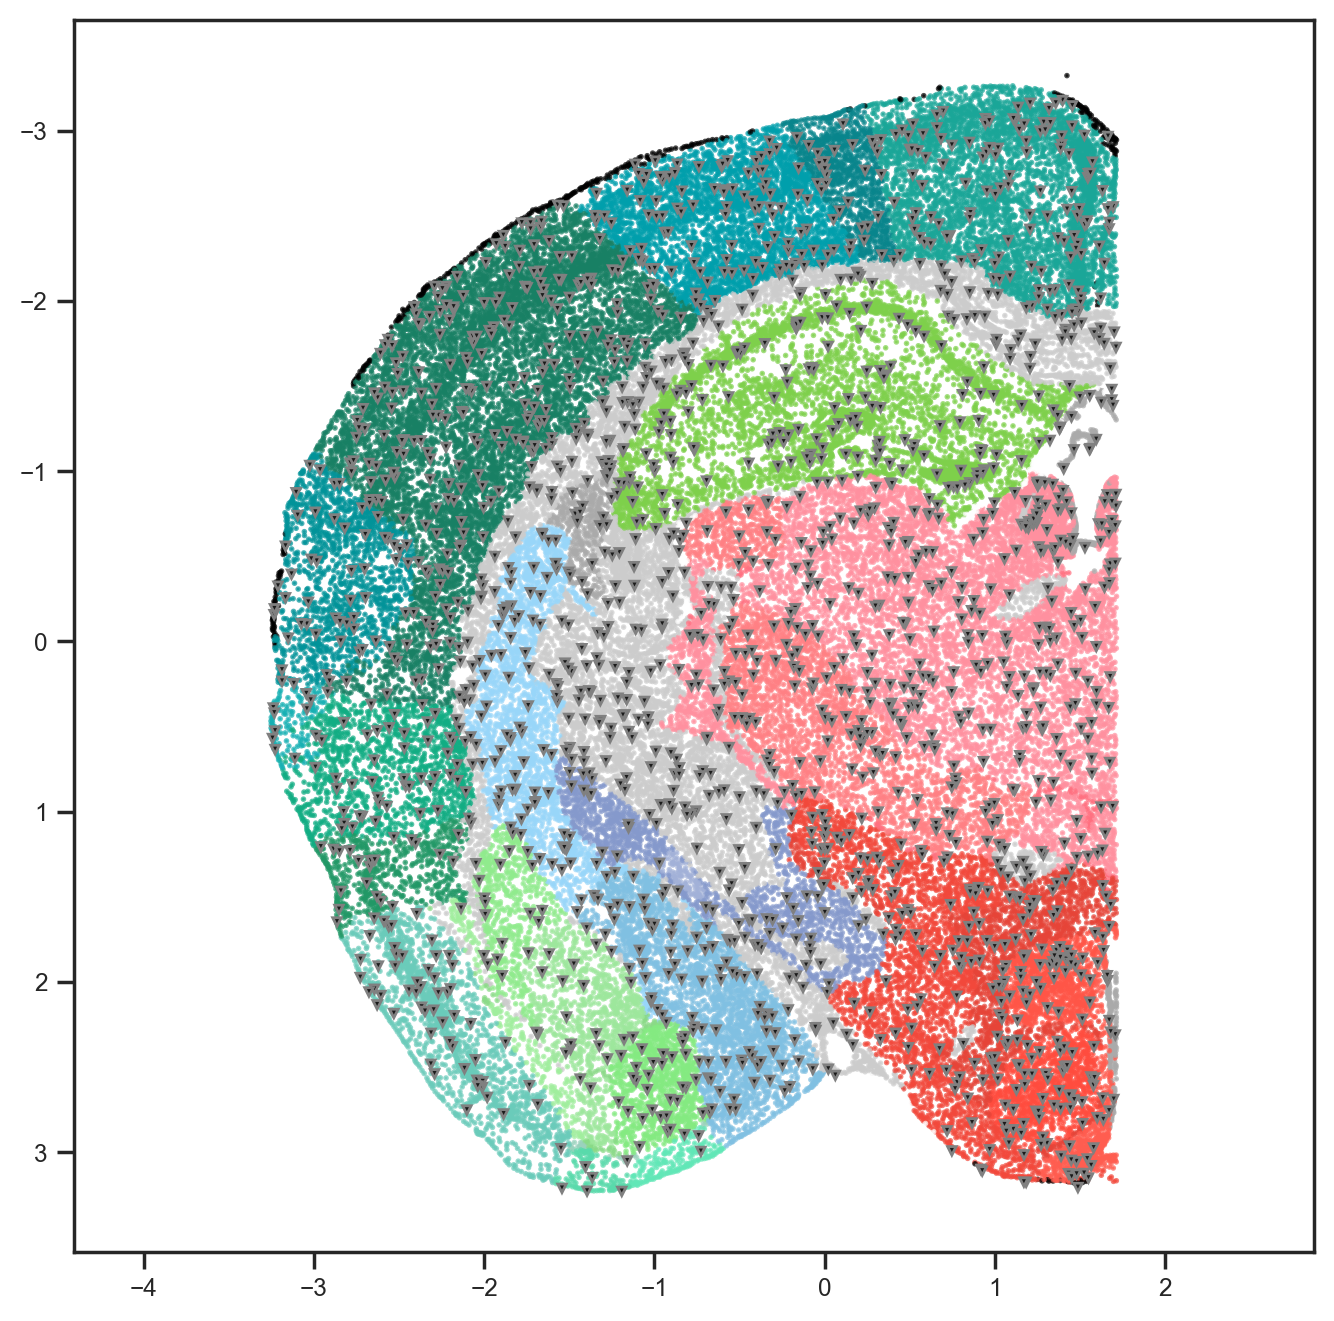

In [9]:
# pick n_arrows from ind randomly
ind = np.where((adata.obs["x_section"] > -np.inf) & (adata.obs["z_section"].round(1) == 6.8))[0]
scale = 5
n_arrows = 2000
arrow_ind = np.random.choice(ind, n_arrows, replace=False)
colors = ["salmon", "dodgerblue"]


f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(xy[ind, 0], xy[ind, 1], s=1, c=adata.obs["parcellation_structure_color"].iloc[ind], alpha=0.7)

for arr in arrow_ind:
    point = xy[arr]

    vec = xy_gamma_pred[arr].squeeze()

    ax.arrow(
        point[0],
        point[1],
        vec[0] * scale,
        vec[1] * scale,
        head_width=0.05,
        head_length=0.05,
        fc="k",
        ec="gray",
        alpha=1,
    )
ax.axis("equal")
ax.invert_yaxis()
plt.show()

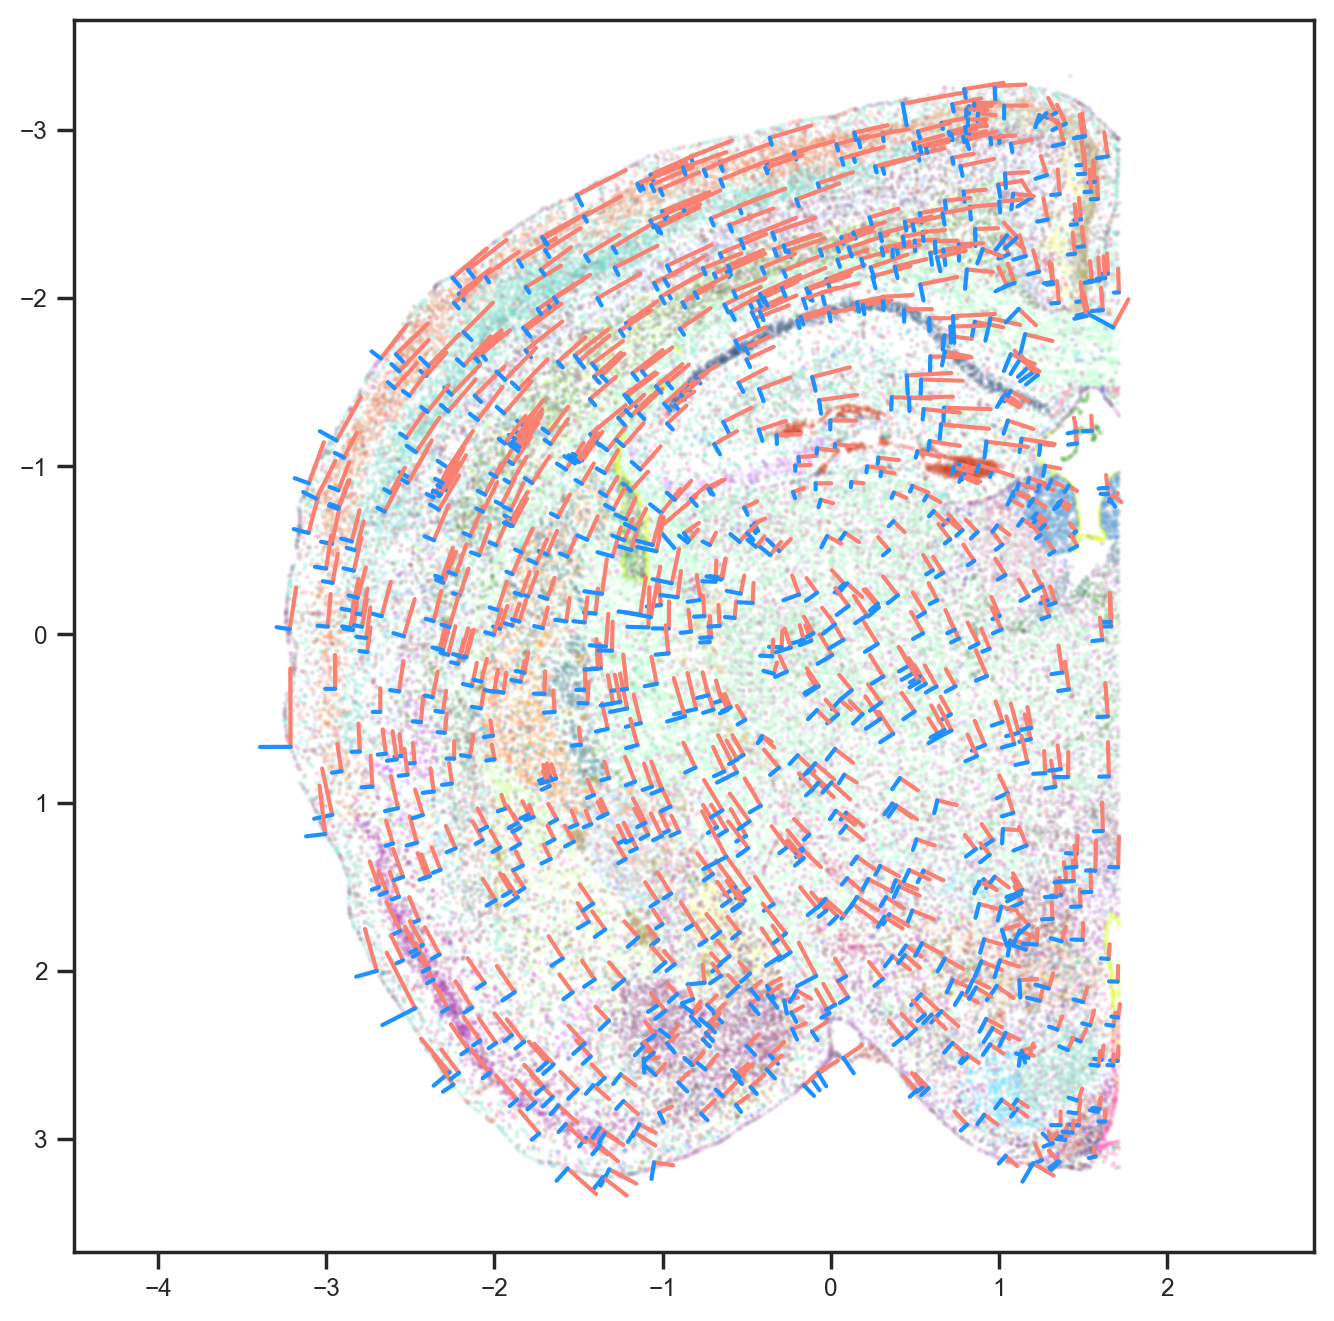

In [10]:
# pick n_arrows from ind randomly
scale = 1
n_arrows = 1000
arrow_ind = np.random.choice(ind, n_arrows, replace=False)
colors = ["salmon", "dodgerblue"]


f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(xy[ind, 0], xy[ind, 1], s=1, c=adata.obs["subclass_color"].iloc[ind], alpha=0.1)

for arr in arrow_ind:
    point = xy[arr]
    srtind = np.argsort(eigvals[arr, :])[::-1]
    for j in range(2):
        vec = eigvecs[arr, :, srtind[j]]
        lam = eigvals[arr, srtind[j]] ** 0.5
        ax.plot(
            [point[0], point[0] + vec[0] * lam * scale],
            [point[1], point[1] + vec[1] * lam * scale],
            c=colors[j],
            alpha=1,
        )
ax.axis("equal")
ax.invert_yaxis()
plt.show()

In [11]:
# data for clustering
data = {
    "eigvals": eigvals,
    "eigvecs": eigvecs,
    "xy_cov_pred": xy_cov_pred,
    "xy_mu_pred": xy_mu_pred,
    "xy_gamma_pred": xy_gamma_pred,
    "xy": xy,
    "section_idx": adata.obs["z_section"].values,
    "subclass": adata.obs["subclass"].values,
    "subclass_color": adata.obs["subclass_color"].values,
    "parcellation_division": adata.obs["parcellation_division"].values,
    "parcellation_division_color": adata.obs["parcellation_division_color"].values,
    "parcellation_structure": adata.obs["parcellation_structure"].values,
    "parcellation_structure_color": adata.obs["parcellation_structure_color"].values,
}

import pickle

pickle.dump(data, open(paths["data_root"] + f"/results/msl_zerogamma.pkl", "wb"))

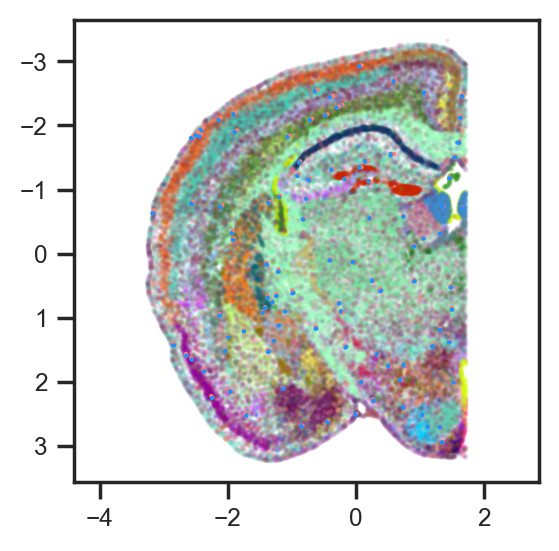

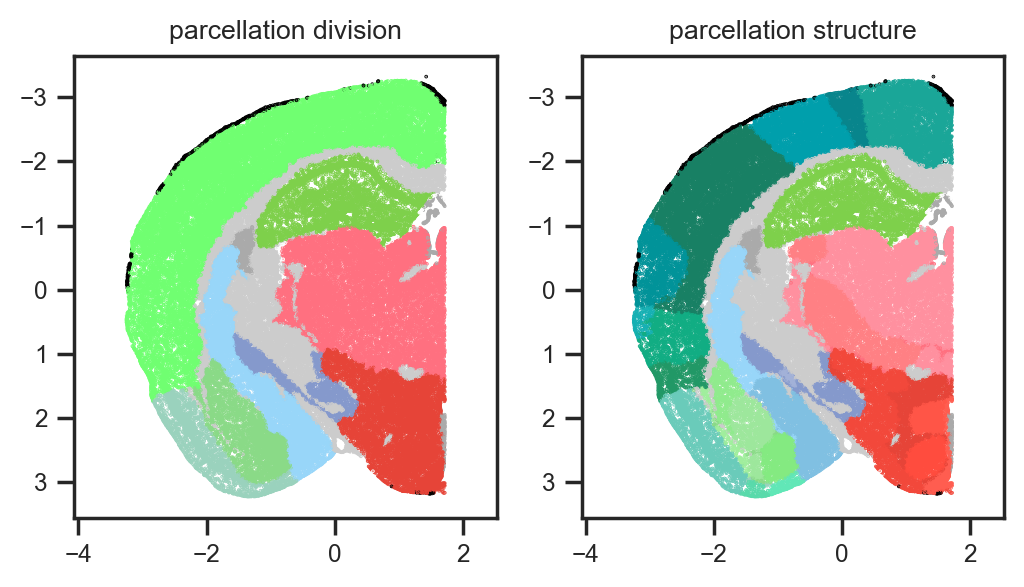

In [12]:
data = pickle.load(open(paths["data_root"] + f"/results/msl_zerogamma.pkl", "rb"))

ind = np.where((adata.obs["x_section"] > -np.inf) & (adata.obs["z_section"].round(1) == 6.8))[0]
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(data["xy"][ind, 0], data["xy"][ind, 1], s=1, c=data["subclass_color"][ind], alpha=0.1)
arrow_ind = np.random.choice(ind, 100, replace=False)
scale = 0.2
colors = ["salmon", "dodgerblue"]
for arr in arrow_ind:
    point = data["xy"][arr]
    for j in range(2):
        vec = data["eigvecs"][arr, :, j]
        lam = data["eigvals"][arr, j] ** 0.5  # get sigma from var
        ax.plot(
            [point[0], point[0] + vec[0] * lam * scale],
            [point[1], point[1] + vec[1] * lam * scale],
            c=colors[j],
            alpha=1,
        )
ax.axis("equal")
ax.invert_yaxis()
plt.show()

f, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].scatter(data["xy"][ind, 0], data["xy"][ind, 1], s=0.1, c=data["parcellation_division_color"][ind], alpha=1)
ax[0].set(title="parcellation division")
ax[0].axis("equal")
ax[0].invert_yaxis()

ax[1].scatter(data["xy"][ind, 0], data["xy"][ind, 1], s=0.1, c=data["parcellation_structure_color"][ind], alpha=1)
ax[1].set(title="parcellation structure")
ax[1].axis("equal")
ax[1].invert_yaxis()
plt.show()